# Import Libraries:

In [153]:
from transformers import pipeline
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Load the Data:

In [2]:
data = pd.read_csv("../data/output/data_clean.csv")
taxonomy = pd.read_csv("../data/input/insurance_taxonomy.csv")

candidate_labels  = taxonomy['label'].str.strip().str.lower().tolist()

# LLM Classification:

In [3]:
classifier = pipeline(
    "zero-shot-classification", model="valhalla/distilbart-mnli-12-1", device=0  # use GPU
)

Device set to use cuda:0


In [4]:
texts = data['full_text'].tolist()
results = classifier(texts, candidate_labels, multi_label=True, batch_size=8)

In [74]:
def extract_labels(result, threshold=0.6, top_k=3):
    selected = [label for label, score in zip(result['labels'], result['scores']) if score > threshold]
    if len(selected) == 0:
        selected = [result['labels'][0]]
    return selected[:top_k]

In [75]:
predicted_labels = [extract_labels(res, threshold=0.7, top_k=3) for res in results]
data['predicted_insurance_labels'] = predicted_labels

# Save Data Predict:

In [77]:
data.to_csv(path_or_buf="../data/output/predicted_labels.csv", index=False)

-----

# Label Distribution Analysis:

In [82]:
all_pred_labels = [lbl for sublist in data['predicted_insurance_labels'] if isinstance(sublist, list) for lbl in sublist]
label_counts = Counter(all_pred_labels)
top_20 = label_counts.most_common(20)
labels_top, counts_top = zip(*top_20)

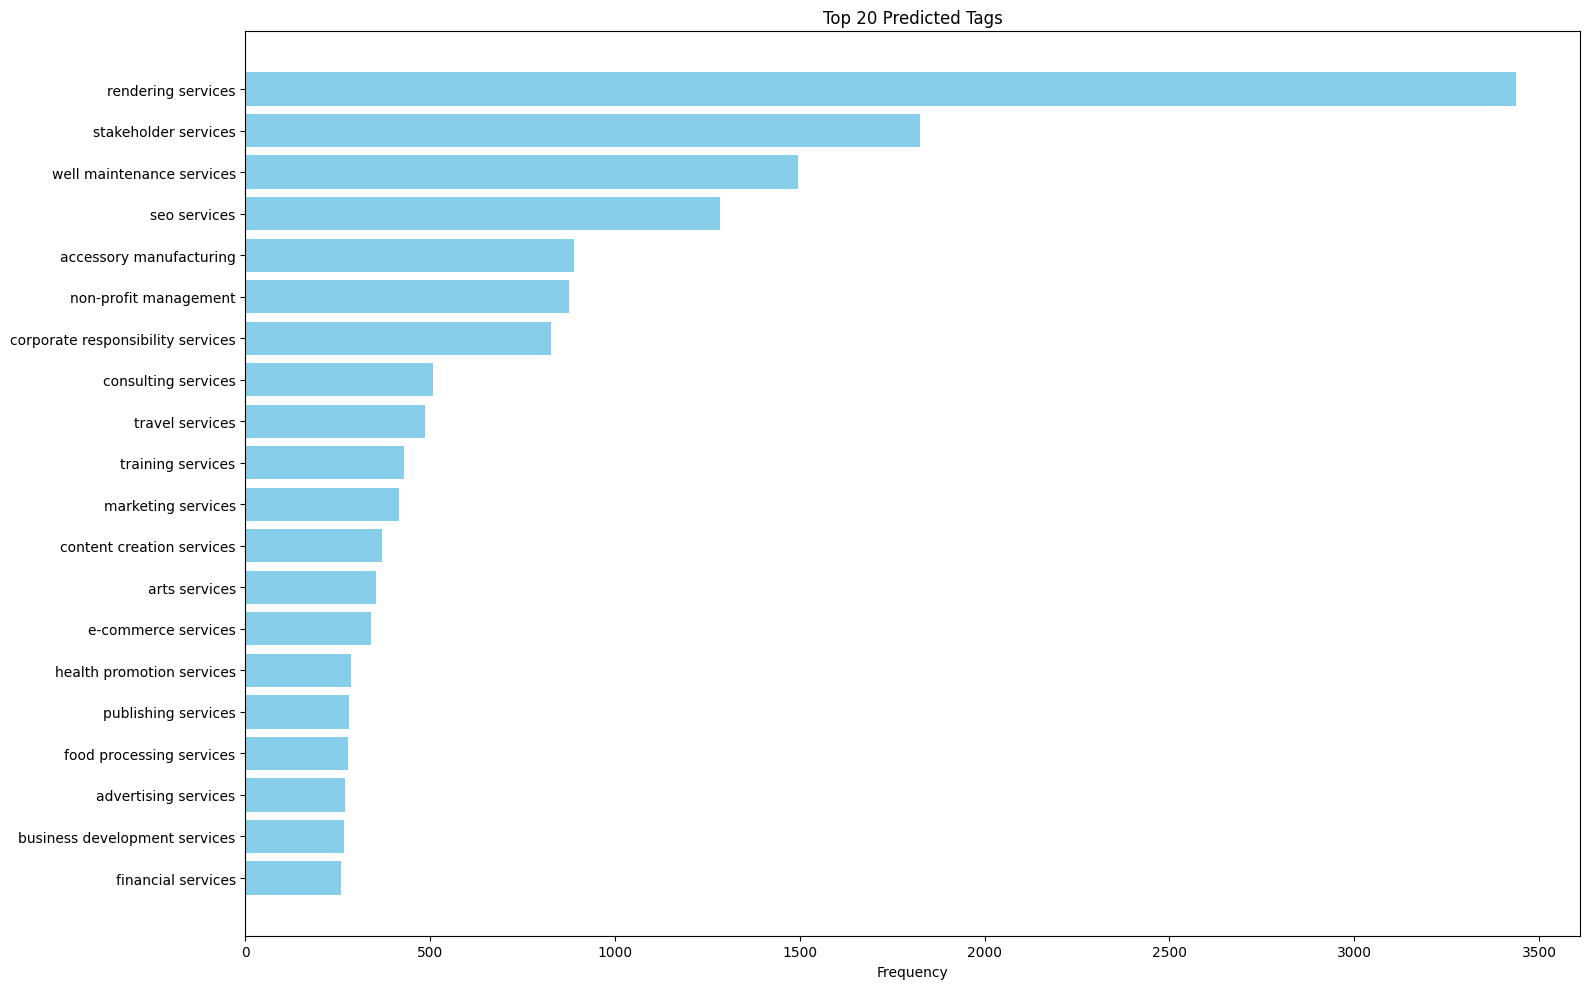

In [83]:
plt.figure(figsize=(16, 10))
plt.barh(labels_top, counts_top, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Predicted Tags')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


--------

# Creating a ground truth set

In [102]:
data_v2 = data.copy
subset = data.sample(n=100, random_state=42).copy()     # generate a subset data for ground truth
subset = subset.reset_index(drop=True)
subset.head()

,full_text,predicted_insurance_labels
0,Texas Industrial Specialties Inc company base ...,[testing and inspection services]
1,company business analyst English translator ba...,[human resources services]
2,company specialize production nonwoven fabric ...,[textile manufacturing services]
3,Mes Teknik industrial kitchen service company ...,"[food processing services, consulting services..."
4,Uparta Capital Moscow base investment firm fou...,"[rendering services, event planning services]"


This dictionary was created manually on 100 lines for validation

In [94]:
ground_truth = {
    0: ["Industrial Machinery Installation", "Project Management Services"],
    1: ["Market Research Services", "Data Analysis Services", "Consulting Services"],
    2: ["Textile Manufacturing Services"],
    3: ["HVAC Installation and Service", "Project Management Services"],
    4: ["Marketing Services", "Financial Services", "Consulting Services"],
    5: ["Industrial Machinery Installation", "Accessory Manufacturing"],
    6: ["Travel Services", "Content Creation Services"],
    7: ["Food Processing Services", "Canning Services"],
    8: ["Plastic Manufacturing"],
    9: ["Legal Services", "Consulting Services"],
    10: ["Chemical Manufacturing", "Food Processing Services", "Business Development Services"],
    11: ["Cosmetic Manufacturing", "Soap Production Services"],
    12: ["Management Consulting", "Technology Consulting"],
    13: ["Drywall Services", "Painting Services"],
    14: ["Commercial Construction Services", "Project Management Services"],
    15: ["Textile Manufacturing Services"],
    16: ["Business Development Services", "Management Consulting"],
    17: ["Steam Services", "Industrial Machinery Installation"],
    18: ["Event Planning Services"],
    19: ["Chemical Manufacturing"],
    20: ["Bakery Production Services", "Confectionery Manufacturing"],
    21: ["Chemical Manufacturing", "Building Cleaning Services", "Water Treatment Services"],
    22: ["Waste Management Services", "Water Treatment Services"],
    23: ["Industrial Machinery Installation"],
    24: ["Media Production Services"],
    25: ["E-Commerce Services"],
    26: ["Content Creation Services", "Travel Services"],
    27: ["Food Processing Services"],
    28: ["Textile Manufacturing Services", "Insurance Services", "Legal Services"],
    29: ["Project Management Services", "Consulting Services"],
    30: ["Wood Product Manufacturing"],
    31: ["Confectionery Manufacturing"],
    32: ["Business Development Services"],
    33: ["General Handyman Services"],
    34: ["Textile Manufacturing Services"],
    35: ["Waste Management Services", "Recycling Services"],
    36: ["Water Treatment Services"],
    37: ["Mobile Home Construction Services", "Real Estate Services"],
    38: ["Travel Services"],
    39: ["Industrial Machinery Installation"],
    40: ["Metal Coating & Engraving Services"],
    41: ["Fine Arts Schools"],
    42: ["Electronics Manufacturing"],
    43: ["Agriculture Technology Services", "Smart Farming Solutions"],
    44: ["IT Services", "Website Development Services", "Handmade Product Retailers"],
    45: ["Livestock Production"],
    46: ["Mining and Commodities Trading", "Financial Services", "Agricultural Product Distribution"],
    47: ["Real Estate Services", "Legal Services"],
    48: ["Tire Manufacturing"],
    49: ["Medical Diagnostic Services", "Precision Medicine Services"],
    50: ["Livestock Production"],
    51: ["Retail Services", "Welding Services"],
    52: ["Desserts, Confectionery and Nut Retailers", "Confectionery Manufacturing"],
    53: ["Information Technology Services", "Aerospace and Defense"],
    54: ["3D Printing Services", "Industrial Machinery Manufacturing"],
    55: ["Media and Entertainment", "Video and Audio Production"],
    56: ["Apparel Manufacturing", "Private Label Manufacturing"],
    57: ["Wood Product Manufacturing", "Sawmills", "Sustainable Forestry"],
    58: ["Retail Services", "Warehouse Clubs and Supercenters"],
    59: ["Agricultural Laboratory Services", "Environmental Testing Services"],
    60: ["Glass and Glazing Contractors", "Staffing Services"],
    61: ["Media and Entertainment", "Sound Recording and Music Publishing", "Environmental Awareness Projects"],
    62: ["Postal Services", "Notary Services", "Local Messengers and Local Delivery"],
    63: ["Gardening Supplies", "Handmade Goods Marketplace", "Miscellaneous Nondurable Goods Wholesalers"],
    64: ["Hardware Merchant Wholesalers", "Locksmith Supplies"],
    65: ["Textile and Fabric Finishing Mills", "Fabric-Based Goods Manufacturing", "Children’s Entertainment Media"],
    66: ["Custom Furniture Manufacturing", "Architectural Woodwork", "Miscellaneous Manufacturing"],
    67: ["Electrical Equipment Manufacturing", "Military Power Supplies", "Customized Power Electronics"],
    68: ["Media and Publishing Services", "Radio Broadcasting Stations"],
    69: ["Cables and Wiring Device Manufacturing", "Retail Security Solutions", "Anti-Theft Display Equipment"],
    70: ["Breakfast Cereal Manufacturing", "Organic Food Production", "Freeze-Dried Fruit Manufacturing"],
    71: ["Other Noncitrus Fruit Farming", "Pumpkin Cultivation", "Tree Farms"],
    72: ["Painting and Wall Covering Contractors", "Food Delivery Services", "Online Ordering Platforms"],
    73: ["Engineering Services", "Mechanical Design Services", "Industrial Machinery Services"],
    74: ["Soil Consolidation Services", "Solar Energy Production Systems", "Construction Materials Manufacturing"],
    75: ["Printing Ink Manufacturing", "Specialty Inks and Coatings", "Graphic Supplies"],
    76: ["Educational Services", "Online Education Platforms", "Automobile Driving Schools"],
    77: ["Mushroom Cultivation", "Agriculture Production", "Farms"],
    78: ["Engine and Generator Manufacturing", "Online Gaming Platforms", "Online Application Development"],
    79: ["Metal Coating and Engraving", "Powder Coating Services", "Rust Removal Services"],
    80: ["Charter Bus Industry", "Transportation Services", "Shuttles and Buses"],
    81: ["Commercial Bakeries", "Food and Bakery Businesses", "Food Production"],
    82: ["Nephrology Clinic", "Kidney Dialysis Centers", "Medical Services"],
    83: ["Physical Commodities Trading", "Transportation Services", "Wholesale Renewable Energy Companies"],
    84: ["Auto Body Shops", "Automotive Body Paint and Interior Repair and Maintenance", "Automotive Body Repair Services"],
    85: ["Funeral Homes and Funeral Services", "Burial Ceremonies Services", "Cremation Services"],
    86: ["Tire Dealers", "Retail Brakes Wheels & Tire Dealers", "Recycling Facility"],
    87: ["Correctional Institutions", "Courthouses", "Educational Services"],
    88: ["Manufacturing Glass Roofs", "Prefabricated Metal Building and Component Manufacturing", "Sliding Systems Manufacturing"],
    89: ["Mesothelioma Sarcoma Information and Resources", "Environmental Engineering Services", "Asbestos-Related Legal Services"],
    90: ["Financial Advisory Services", "Investment Management Services", "Mortgage Brokers"],
    91: ["Photofinishing Laboratories Except One-Hour", "Photographers & Photographic Studios", "Desktop Wallpaper Services"],
    92: ["Other Building Equipment Contractors", "Security Services", "Gate Opener Installation"],
    93: ["Retail Seasonal Flower Arrangements", "Floral Arrangement Services", "Wholesale Florists"],
    94: ["Manufacturing Military Armored Vehicle", "Armored Vehicle Design", "Security Systems Integrator"],
    95: ["Saw Blade and Handtool Manufacturing", "Camping Knives Manufacturer", "Tactical Shovel Manufacturer"],
    96: ["Warehousing & Storage", "Storage Facilities", "Freight Transportation Arrangement"],
    97: ["Oil and Gas Wells Drilling", "Online Retail", "Oil & Gas Exploration and Production Services"],
    98: ["Custom-Made Furniture Manufacturing", "Kitchen and Bathroom Design", "Furniture Stores"],
    99: ["Office Administrative Services", "Virtual Assistant Services", "Admin & Customer Support Services"]
}

In [97]:
cleaned_ground_truth = {
    k: [label.lower().strip() for label in v]
    for k, v in ground_truth.items()
}

In [98]:
subset["true_labels"] = subset.index.to_series().map(cleaned_ground_truth)

In [101]:
subset.to_csv(path_or_buf="../data/output/ground_truth.csv", index=False)

# Evaluation With Metrics (F1, Precision, Recall) using Ground Truth data created:

In [152]:
ground_truth_data = pd.read_csv("../data/output/ground_truth.csv")


ground_truth_data["predicted_insurance_labels"] = (
    ground_truth_data['predicted_insurance_labels']
    .str.replace(r"[\[\]']", "", regex=True)
    .str.lower()
    .str.strip()
    .str.replace("''", "")
    .str.replace('"', '')
)
ground_truth_data["true_labels"] = (
    ground_truth_data['true_labels']
    .str.replace(r"[\[\]']", "", regex=True)
    .str.lower()
    .str.strip()
    .str.replace("''", "")
    .str.replace('"', '')
)
ground_truth_data.head()

,full_text,predicted_insurance_labels,true_labels
0,Texas Industrial Specialties Inc company base ...,testing and inspection services,"industrial machinery installation, project man..."
1,company business analyst English translator ba...,human resources services,"market research services, data analysis servic..."
2,company specialize production nonwoven fabric ...,textile manufacturing services,textile manufacturing services
3,Mes Teknik industrial kitchen service company ...,"food processing services, consulting services,...","hvac installation and service, project managem..."
4,Uparta Capital Moscow base investment firm fou...,"rendering services, event planning services","marketing services, financial services, consul..."


In [149]:
mlb = MultiLabelBinarizer()

y_true = mlb.fit_transform(ground_truth_data['true_labels'])
y_pred = mlb.transform(ground_truth_data['predicted_insurance_labels'])

In [150]:
f1 = f1_score(y_true, y_pred, average='samples')
precision = precision_score(y_true, y_pred, average='samples')
recall = recall_score(y_true, y_pred, average='samples')

In [151]:
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

F1-Score: 0.8326297285447979
Precision: 0.864426368285922
Recall: 0.8305065194650401
